In [690]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import random
random.seed('stoked')

Discussion
==========

After using an initial linear regression approach to predict return values, I changed the problem definition 
to predict the direction of the SPX for different return periods based on the feature set. 
This seemed conceptually simpler to do. To do this I encoded the sign of returns for a given return period 
and the problem is simply to classify the target as positive or negative. The hypothesis suggests the sign of the future return may be sufficient information to trade on.  

Since the problem shifted to a classification problem I dropped the linear regression model and instead opted for several linear classifiers. I don't have any priors about which model is 'best' for which types of data and since the target variable is pretty equally balanced between positive and negative this 'kitchen sink' approach seemed like an appropriate strategy. The pipeline approach simply lets me swap in different models relatively easily. 


The pipeline selects features, fits, predicts, evaluates the models and uses walk-forward train-test split so that the models would be able to see different temporally ordered sections of the data. I dropped two of the datasets to increase time to learn the data. In terms of pure model evaluation, they were scored according to precision, recall, accuracy and F1 score and each time fold. The final model evaluation computes the mean for each of those summary statistics across the time folds, collapsing that dimension of the data, and presents a final model score for each return period. 

I tested a few variations for n_features and ultimately landed on 3. 

While the performance for Bernoulli and Logistic models tends to be higher, AdaBoostClassifier_21 is the overwhelming winner model if I consider how a strategy using it would perform on walk-forward validation. The features used for AdaBoostClassifier_21 were '% Away From 200d MA', '21d MA of Breakdown', and 'EM - USA Sharpe'. 

As an experiment, I wanted to see if

This suggests that it matters when returns/losses exhibit behavior that exceeds some order of standard deviation. In order to understand this better, I decided to take a look at the binned data in 'Centroids' file. For each T + day return I encode return days that fell in bin 1 or 10 as a tail event. Initially, I simplify this problem to simply trying to predict a tail event on 'T + 21' with the tail-event encoded data of 'T + 3' and 'T + 10'. I apply the same pipeline as before, with the same temporal walk-forward validation of models. The performance of the models in general is only slightly better than the underlying distribution of tail event instances in the data. 

#run some ml stuff
#check the 'goodness' of the model
#normalize the columns, rerun and evaluate
#add in other columns and rerun, evaluate
#add in other columns normalize, rerun, evaluate
#feature engineer the columns

In [2]:
#helper function to make sense of excel serial date format
import datetime

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1900, 1, 1)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

In [326]:
#io
fls1 = glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.txt')
fls2= glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.TXT')
fls_all = fls1[:1] + fls2[:5] + fls2[6:]

In [13]:
#construct feature matrix
#two data sources have been excluded for initial analysis

def construct_feature_matrix(fls_all):
    '''
    Constructs a feature matrix after some data cleaning
    '''
    dfs = []
    for fl in fls_all:
        df = pd.read_csv(fl)
        col_name = df.columns[1]
        df['date'] = df['Lookup'].apply(xldate_to_datetime)
        df = df.drop('Lookup', axis=1)
        df = df.set_index(keys='date')
        dfs.append(df)

    feature_matrix = pd.concat([df for df in dfs], join='inner', axis=1)
    feature_matrix = feature_matrix.dropna()
    
    return feature_matrix

In [382]:
def evaluate_model(predictions,returns):
    '''
    
    '''
    comparison = pd.DataFrame()
    comparison['returns'] = returns
    comparison['prediction'] = predictions
    comparison['strategy'] = comparison['prediction'] * comparison['returns']
    
    return comparison

In [9]:
def clean_target(path):
    targets = pd.read_csv(path)
    targets['date'] = targets['Lookup'].apply(xldate_to_datetime)
    targets = targets.set_index(keys='date').drop('Lookup', axis=1).dropna()
    return targets

In [329]:
def onesdv(row):
    onesdv = 0
    if row < 3:
        onesdv = -1
    if row > 8:
        onesdv = 1
    return onesdv

In [652]:
feature_matrix = construct_feature_matrix(fls_all)
features = feature_matrix.columns
targets = clean_target('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
features_targets = pd.concat([feature_matrix, targets], join='inner', axis = 1)
features_targets = features_targets.dropna(axis=0)


In [730]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest
from sklearn import decomposition
#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    ]

# Logging for Visual Comparison
log_cols=["Day", "Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

model_test_period_returns = {}
feature_dict_sign = {}

#todo
for day in ["3", "10", "21"]:
    
    feature_dict_sign[day] = {}
    
    for clf in classifiers:
        
        name = clf.__class__.__name__
        
        
        
        selector = RFE(clf, 3, step=1)
        selector = selector.fit(features_targets[features], np.sign(features_targets[day]))
        model_features = features[np.where(selector.ranking_ == 1)[0]]
        feature_dict_sign[day][name] = model_features
        
        
        tscv = TimeSeriesSplit(n_splits=10)
        fold = 1
        for train_index, test_index in tscv.split(features_targets[features]):
            #print(test_index)
            X_train = features_targets[model_features][:train_index[-1]]
            y_train = features_targets[day][:train_index[-1]]
            X_test = features_targets[model_features][train_index[-1]:]
            y_test = features_targets[day][train_index[-1]:]

            clf.fit(X_train, np.sign(y_train))
           
            test_predictions = clf.predict(X_test)
            acc = accuracy_score(np.sign(y_test.values), test_predictions)


            precision = precision_score(np.sign(y_test.values), test_predictions, average='micro')
            recall = recall_score(np.sign(y_test.values), test_predictions, average='micro')
            f1 = f1_score(np.sign(y_test.values), test_predictions, average='micro')
    


            log_entry = pd.DataFrame([[day, name, fold, acc*100, precision, recall, f1]], columns=log_cols)
            log_entry = log_entry.set_index(keys='Classifier')
            log = log.append(log_entry)
            fold += 1
        model_test_period_returns[str(name) + '_' + day ] = evaluate_model(test_predictions, features_targets[day][train_index[-1]:])

log = log.dropna(axis=1)

In [728]:
log.groupby([log.index, 'Day']).mean()

Accuracy        F1  Precision    Recall
                           Day                                          
AdaBoostClassifier         10   54.934560  0.549346   0.549346  0.549346
                           21   57.391534  0.573915   0.573915  0.573915
                           3    52.826991  0.528270   0.528270  0.528270
BernoulliNB                10   59.225390  0.592254   0.592254  0.592254
                           21   62.796862  0.627969   0.627969  0.627969
                           3    56.502980  0.565030   0.565030  0.565030
GradientBoostingClassifier 10   53.636591  0.536366   0.536366  0.536366
                           21   56.647647  0.566476   0.566476  0.566476
                           3    53.928482  0.539285   0.539285  0.539285
LinearDiscriminantAnalysis 10   55.074595  0.550746   0.550746  0.550746
                           21   59.470902  0.594709   0.594709  0.594709
                           3    55.240278  0.552403   0.552403  0.552403
LogisticRegression         10   57.635595  0.576356   0.576356  0.576356
                           21   63.424899  0.634249   0.634249  0.634249
                           3    57.046984  0.570470   0.570470  0.570470
RandomForestClassifier     10   51.875518  0.518755   0.518755  0.518755
                           21   55.466308  0.554663   0.554663  0.554663
                           3    51.163245  0.511632   0.511632  0.511632

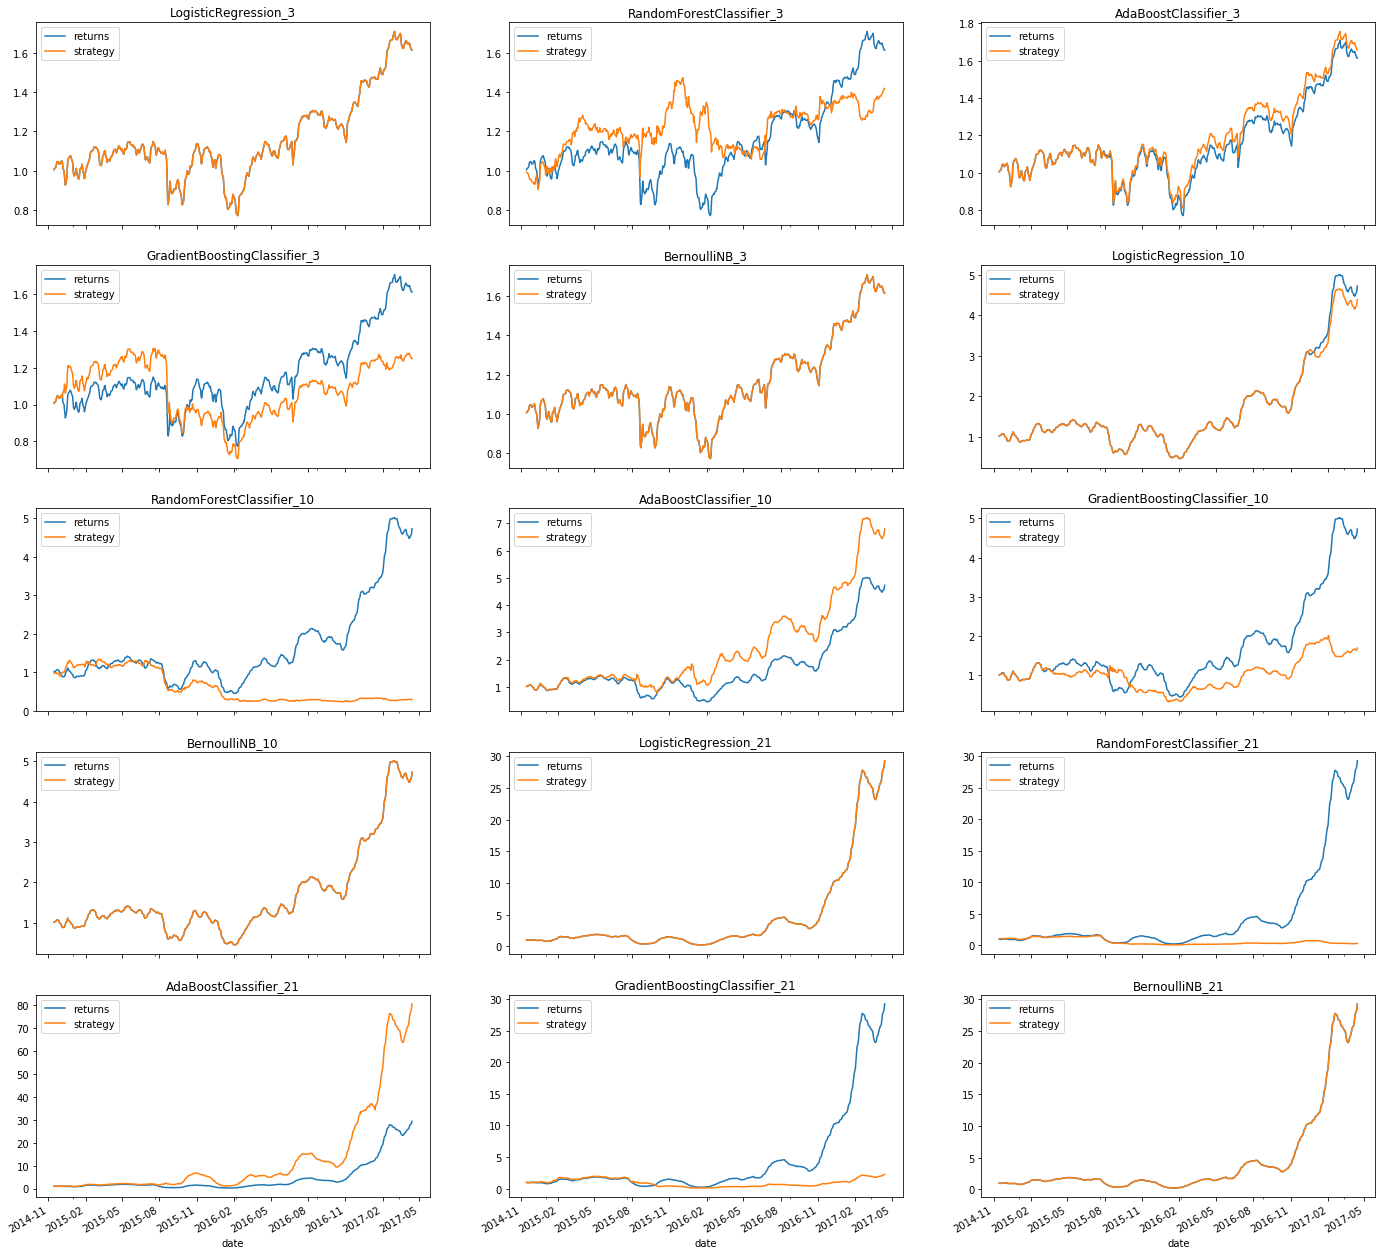

In [731]:
fig, axes = plt.subplots(5, 3, figsize=(24, 24), sharex=True)

for i, model in enumerate(model_test_period_returns.keys()):
    
    model_test_period_returns[model][['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(model)

In [ ]:
ADABOOST does ok in the testing period

In [718]:
model_test_period_returns['AdaBoostClassifier_10'][['returns', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)

In [707]:
feature_dict_sign['10']['AdaBoostClassifier']

Index(['% Away From 200d MA', '21d MA of Breakdown', 'EM - USA Sharpe'], dtype='object')

In [727]:
model_test_period_returns['AdaBoostClassifier_21'][['returns', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)

,returns,strategy
date,,
2017-04-14,29.27774,80.423646


In [682]:
feature_dict_sign['21']['AdaBoostClassifier']

Index(['% Away From 200d MA', '21d MA of Breakdown', 'EM - USA Sharpe'], dtype='object')

In [665]:
centroids = pd.read_csv('/Users/livingdharma/Downloads/ProgrammingTest/spxFwdRetHistQCentroids.csv')
centroids['date'] = centroids['Date'].apply(xldate_to_datetime)
centroids.drop('Date', axis=1, inplace=True)
centroids = centroids.set_index(keys='date')
centroids['onesdv_3'] = centroids['3'].apply(onesdv)
centroids['onesdv_10'] = centroids['10'].apply(onesdv)
centroids['onesdv_21'] = centroids['21'].apply(onesdv)
centroids['return_3'] = targets['3']
centroids['return_10'] = targets['10']
centroids['return_21'] = targets['21']
features_targets_sd = pd.concat([feature_matrix, centroids], join='inner', axis = 1)
features_targets_sd = features_targets_sd.drop(['3', '10', '21'], axis =1)


In [732]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    ]

# Logging for Visual Comparison
log_cols=["Day", "Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

# test_pred_cols = ['Day', 'Classifier', 'Predictions']
# test_preds = pd.DataFrame(columns=test_pred_cols)

model_test_period_returns_sd = {}
feature_dict = {}

for day in ["onesdv_3", "onesdv_10", "onesdv_21"]:
    
    feature_dict[day] = {}
    
    for clf in classifiers:
        
        name = clf.__class__.__name__
        
        
        
        selector = RFE(clf, 5, step=1)
        selector = selector.fit(features_targets_sd[features], features_targets_sd[day])
        model_features = features[np.where(selector.ranking_ == 1)[0]]
        feature_dict[day][name] = model_features
        
        tscv = TimeSeriesSplit(n_splits=10)
        fold = 1
        for train_index, test_index in tscv.split(features_targets[model_features]):
            
            #accounting
            X_train = features_targets_sd[model_features][:train_index[-1]]
            y_train = features_targets_sd[day][:train_index[-1]]
            X_test = features_targets_sd[model_features][train_index[-1]:]
            y_test = features_targets_sd[day][train_index[-1]:]


            #ml magic
            clf.fit(X_train, y_train)
            test_predictions = clf.predict(X_test)
        
            #compute our metrics
            acc = accuracy_score(y_test.values, test_predictions)
            precision = precision_score(y_test.values, test_predictions, average='micro')
            recall = recall_score(y_test.values, test_predictions, average='micro')
            f1 = f1_score(y_test.values, test_predictions, average='micro')
    

            #accounting and bookkeeping 
            log_entry = pd.DataFrame([[day, name, fold, acc*100, precision, recall, f1]], columns=log_cols)
            log_entry = log_entry.set_index(keys='Classifier')
            log = log.append(log_entry)
            fold += 1
        
        #lets see our models perform in the final test period
        model_test_period_returns_sd[str(name) + '_' + day ] = evaluate_model(test_predictions, features_targets_sd['return_' + day.split('_')[1]][train_index[-1]:])

log = log.dropna(axis=1)

In [695]:
log.groupby([log.index, 'Day']).mean()

Accuracy        F1  Precision    Recall
                           Day                                                
AdaBoostClassifier         onesdv_10  60.768362  0.607684   0.607684  0.607684
                           onesdv_21  62.568389  0.625684   0.625684  0.625684
                           onesdv_3   63.200055  0.632001   0.632001  0.632001
BernoulliNB                onesdv_10  67.339682  0.673397   0.673397  0.673397
                           onesdv_21  69.406300  0.694063   0.694063  0.694063
                           onesdv_3   64.226687  0.642267   0.642267  0.642267
GradientBoostingClassifier onesdv_10  59.643816  0.596438   0.596438  0.596438
                           onesdv_21  62.559365  0.625594   0.625594  0.625594
                           onesdv_3   60.650234  0.606502   0.606502  0.606502
LinearDiscriminantAnalysis onesdv_10  66.307607  0.663076   0.663076  0.663076
                           onesdv_21  67.000346  0.670003   0.670003  0.670003
                           onesdv_3   62.665193  0.626652   0.626652  0.626652
LogisticRegression         onesdv_10  67.217797  0.672178   0.672178  0.672178
                           onesdv_21  69.358736  0.693587   0.693587  0.693587
                           onesdv_3   64.323557  0.643236   0.643236  0.643236
RandomForestClassifier     onesdv_10  60.392739  0.603927   0.603927  0.603927
                           onesdv_21  61.905813  0.619058   0.619058  0.619058
                           onesdv_3   56.178298  0.561783   0.561783  0.561783

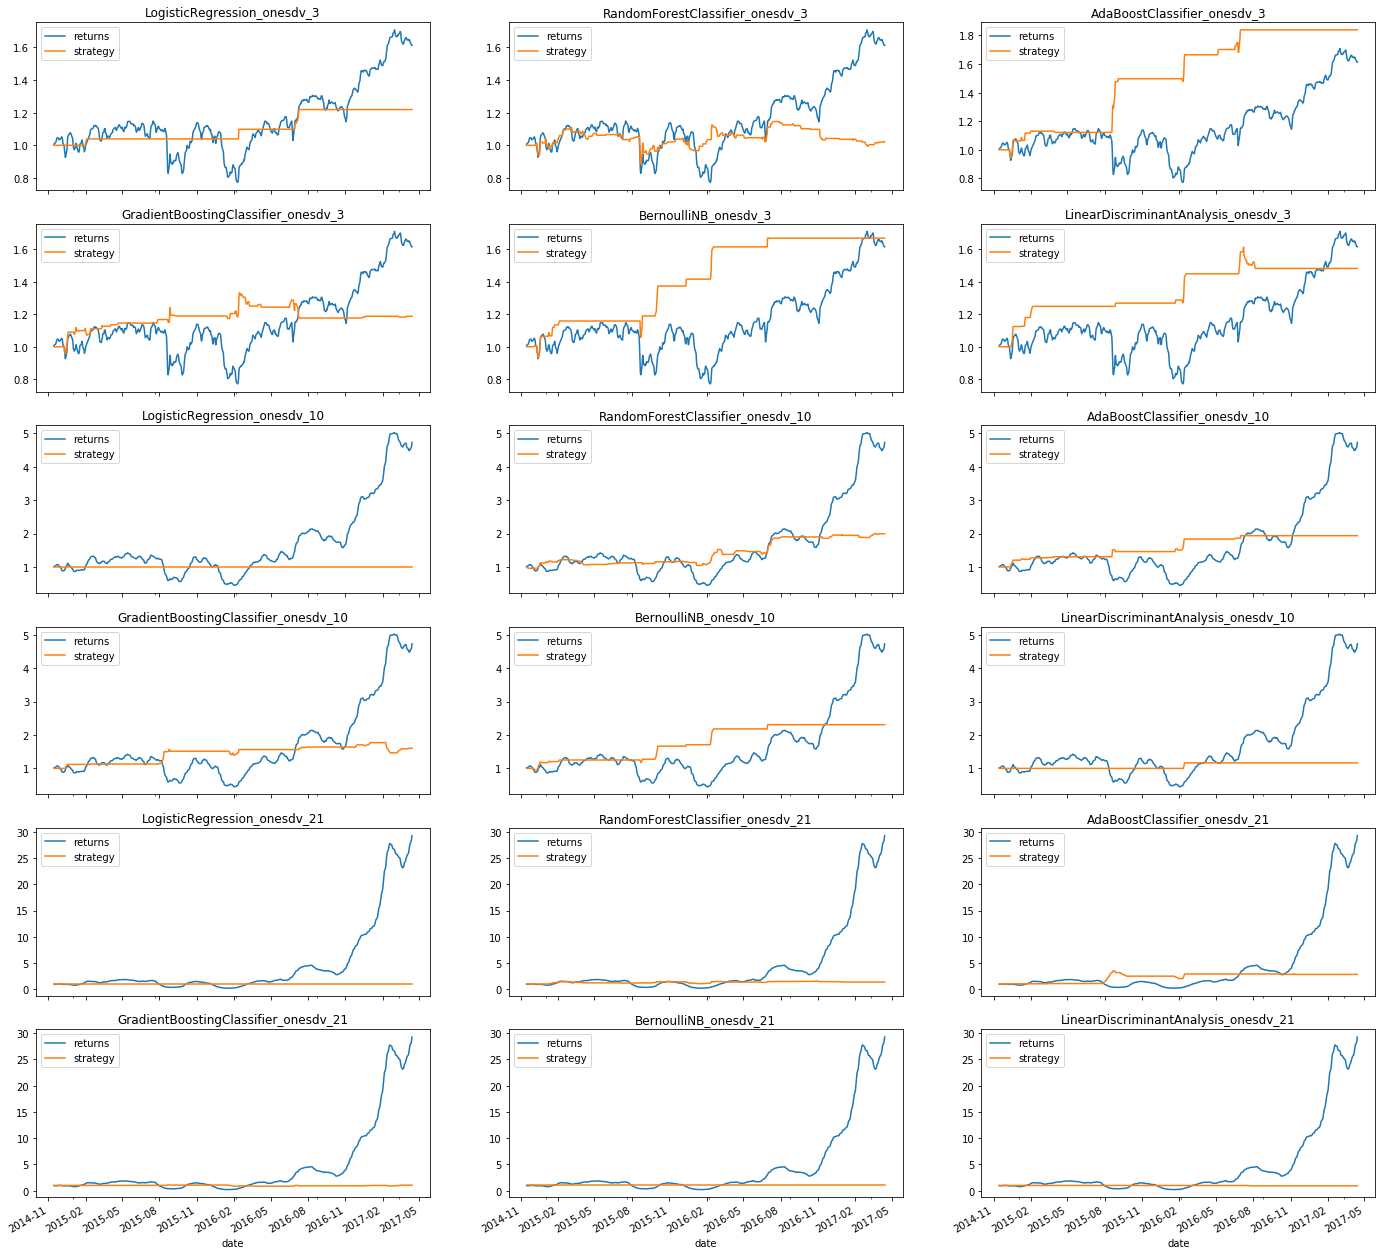

In [696]:
fig, axes = plt.subplots(6, 3, figsize=(24, 24), sharex=True)

for i, model in enumerate(model_test_period_returns.keys()):
    
    model_test_period_returns_sd[model][['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(model)